# Here in this Notebook we have performed some Analysis
1. We did model analysis of Customized VGG16 and Customized Xception 
2. We plotted the Confusion Matrix
3. Found the accuracy of VGG16 and Xception before training

In [3]:
import os
from pathlib import Path

import PIL
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.python.keras.applications import VGG16,Xception
from tensorflow.python.keras.applications.vgg16 import decode_predictions
from tensorflow.python.keras.layers import Dense, Flatten, Dropout
from tensorflow.python.keras.models import Model, Sequential, load_model
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from numpy import array,argmax
import numpy as np
from skimage.transform import resize
from random import shuffle
from sklearn.metrics import confusion_matrix
import itertools

In [2]:
class MyModel:
    def __init__(self):
        self.model=None

     #get the input shape of our model
    def get_input_shape(self,model):
        return model.layers[0].output_shape[1:3]

    def get_vgg_model(self):
        self.model = VGG16(include_top=True, weights='imagenet')
        return self.model
    
    def get_inception_model(self):
        self.model = Xception(include_top=True, weights='imagenet')
        return self.model

    #build our VGG16 with custom layers. Transfer Learning
    def build_with_vgg(self,n_classes,model):
        #model = self.model
        transfer_layer = model.get_layer('block5_pool')
        conv_model = Model(inputs=model.input,
                           outputs=transfer_layer.output)
        # we would train only our changed last layers, we will not the weights of VGG16
        conv_model.trainable = False
        #According to the experiments conducted, changing block 5 and block 4 to traininable gives out best results 
        for layer in conv_model.layers:
            if('block5' in layer.name or 'block4' in layer.name):
                layer.trainable = True
            layer.trainable = False
        new_model = Sequential()
        new_model.add(conv_model)
        new_model.add(Flatten())
        new_model.add(Dense(1024, activation='relu'))
        new_model.add(Dropout(0.5))
        new_model.add(Dense(n_classes, activation='softmax'))
        return new_model
    
    def build_with_xception(self,classes,model):
        transfer_layer = model.get_layer('block14_sepconv2_act')
        conv_model = Model(inputs=model.input,
                           outputs=transfer_layer.output)
         # we would train only our changed last layers, we will not the weights of VGG16
        conv_model.trainable = False
        #According to the experiments conducted, changing block 5 and block 4 to traininable gives out best results 
        for layer in conv_model.layers:
            if('block14' in layer.name or 'block13' in layer.name):
                layer.trainable = True
            layer.trainable = False
        new_model = Sequential()
        new_model.add(conv_model)
        new_model.add(Flatten())
        new_model.add(Dense(1024, activation='relu'))
        new_model.add(Dropout(0.5))
        new_model.add(Dense(n_classes, activation='softmax'))
        return new_model

    #complile the built model(picks up the changes done in the pretrained models)
    def compile_model(self,new_model):
        # our minimizer
        optimizer = Adam(lr=1e-5)
        loss = 'categorical_crossentropy'
        metrics = ['categorical_accuracy']
        new_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    # initialize the Keras in built Image generator, used for image manipulations
    def image_generator(self):
        img_generator = ImageDataGenerator(
            horizontal_flip=True,
            vertical_flip=True,
            rescale=1. / 255,
            rotation_range=180,
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0.1,
            zoom_range=[1.0, 1.5],
            fill_mode='nearest')
        return img_generator


    # Method to return the image generator
    def data_generator(self,train_dir,shape):
        img_generator = self.image_generator()
        return img_generator.flow_from_directory(directory=train_dir,
                                                    target_size=shape,
                                                    shuffle=True)

    def path_join(self,dirname, filenames):
        return [os.path.join(dirname, filename) for filename in filenames]

    #prints the model layers, this is the in built functionality of keras
    def print_model_summary(self,model):
        model.summary()
        
    #predict a sample image for vgg
    def predict_for_vgg(self,image_path, cls,img_shape,new_model):
        print("Intial prediction made by Pretrained model")
        img = PIL.Image.open(image_path)
        img_resized = img.resize(img_shape, PIL.Image.LANCZOS)
        plt.imshow(img_resized)
        plt.title("Original class: {0}".format(cls))
        plt.show()
        img_array = np.expand_dims(np.array(img_resized), axis=0)
        pred = new_model.predict(img_array)
        pred_decoded = decode_predictions(pred)[0]
        for code, name, score in pred_decoded:
            print("{0:>6.2%} : {1}".format(score, name))
            
     #predict a sample image for xception
    def predict_for_xception(self,image_path, cls,new_model):
        print("Intial prediction made by Pretrained model")
        img = PIL.Image.open(image_path)
        #img_resized = img.resize(img_shape, PIL.Image.LANCZOS)
        plt.imshow(img)
        plt.title("Original class: {0}".format(cls))
        plt.show()
        img_array = np.expand_dims(np.array(img), axis=0)
        pred = new_model.predict(img_array)
        pred_decoded = decode_predictions(pred)[0]
        for code, name, score in pred_decoded:
            print("{0:>6.2%} : {1}".format(score, name))


### Our classes

In [3]:
cols = ['Label','Latin Name', 'Common Name','Train Images', 'Validation Images']
df = pd.read_csv("../data/monkey_labels.txt", names=cols, skiprows=1)
df

Label                Latin Name                      Common Name  \
0  n0         alouatta_palliata\t    mantled_howler                   
1  n1        erythrocebus_patas\t    patas_monkey                     
2  n2        cacajao_calvus\t        bald_uakari                      
3  n3        macaca_fuscata\t        japanese_macaque                 
4  n4       cebuella_pygmea\t        pygmy_marmoset                   
5  n5       cebus_capucinus\t        white_headed_capuchin            
6  n6       mico_argentatus\t        silvery_marmoset                 
7  n7      saimiri_sciureus\t        common_squirrel_monkey           
8  n8       aotus_nigriceps\t        black_headed_night_monkey        
9  n9       trachypithecus_johnii    nilgiri_langur                   

   Train Images  Validation Images  
0           131                 26  
1           139                 28  
2           137                 27  
3           152                 30  
4           131                 26  
5           141                 28  
6           132                 26  
7           142                 28  
8           133                 27  
9           132                 26

### Initialize our Class

In [4]:
modelObj = MyModel()

### Training Data 

In [5]:
train_directory = Path('../data/training')
#get VGG16
model = modelObj.get_vgg_model()
#generator for our train data
input_shape = modelObj.get_input_shape(model)
generator_train = modelObj.data_generator(train_directory,input_shape)

Found 1097 images belonging to 10 classes.


### Test Data

In [6]:
train_directory = Path('../data/validation')
#get VGG16
model = modelObj.get_vgg_model()
#generator for our train data
input_shape = modelObj.get_input_shape(model)
generator_test = modelObj.data_generator(train_directory,input_shape)

Found 272 images belonging to 10 classes.


## VGG Model Summary

In [7]:
#VGG16 model Summary
model = modelObj.get_vgg_model()
modelObj.print_model_summary(model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

## Xception Model Summary

In [8]:
#Xception Model Summary
x_model = modelObj.get_inception_model()
modelObj.print_model_summary(x_model)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_4 (InputLayer)             (None, None, None, 3) 0                                            
____________________________________________________________________________________________________
block1_conv1 (Conv2D)            (None, None, None, 32 864         input_4[0][0]                    
____________________________________________________________________________________________________
block1_conv1_bn (BatchNormalizat (None, None, None, 32 128         block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_conv1_act (Activation)    (None, None, None, 32 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

## VGG16 Sample Prediction

Found 1097 images belonging to 10 classes.
Intial prediction made by Pretrained model


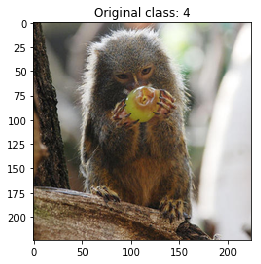

46.09% : macaque
31.80% : titi
12.21% : marmoset
 3.80% : baboon
 3.57% : guenon


In [9]:
train_directory = Path('../data/training')

#get VGG16
model = modelObj.get_vgg_model()

#generator for our train data
input_shape = modelObj.get_input_shape(model)
generator_train = modelObj.data_generator(train_directory,input_shape)

# number of classes of train data
n_classes = generator_train.num_class

#get the train images path
train_image_paths = modelObj.path_join(train_directory, generator_train.filenames)

#get the classes of train data
cls_train = generator_train.classes

#VGG prediction of our data
modelObj.predict_for_vgg(train_image_paths[500],cls_train[500],modelObj.get_input_shape(model),model)

## Xception Sample Prediction

Found 1097 images belonging to 10 classes.
Intial prediction made by Pretrained model


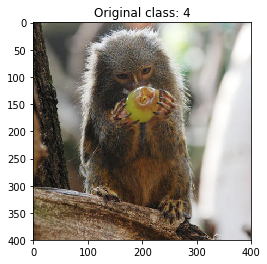

100.00% : mixing_bowl
 0.00% : German_shepherd
 0.00% : safety_pin
 0.00% : pencil_sharpener
 0.00% : groenendael


In [10]:
train_directory = Path('../data/training')

#get VGG16
model = modelObj.get_inception_model()

#generator for our train data
input_shape = modelObj.get_input_shape(model)
generator_train = modelObj.data_generator(train_directory,input_shape)

# number of classes of train data
n_classes = generator_train.num_class

#get the train images path
train_image_paths = modelObj.path_join(train_directory, generator_train.filenames)

#get the classes of train data
cls_train = generator_train.classes

#Inception prediction of our data
modelObj.predict_for_xception(train_image_paths[500],cls_train[500],model)

-------------------------------------------------------------------------------------------------------------------------------

# Confusion Matrix for Trained Model

In [1]:
class ExtractData(object):
    # we have 10 features which are divided into below mentioned categories
    def __init__(self, directory):
        self.categories = ["n0", "n1", "n2", "n3", "n4", "n5", "n6", "n7", "n8", "n9"]
        self.label_encoder = LabelEncoder()
        self.onehot_encoder = OneHotEncoder(sparse=True)
        self.directory = directory
        self.img_shape = (224,224)
        cols = ['Label','Latin Name', 'Common Name','Train Images', 'Validation Images']
        self.df = pd.read_csv("../data/monkey_labels.txt", names=cols, skiprows=1)
        self.classes = 10
        
    # turn our categorical value into One-Hot encoding for classification
    def get_one_hot_vector(self):
        values = array(self.categories)  # same as above array[]
        int_encoded = self.label_encoder.fit_transform(values)  # [0,1,2,3,4,5,6,7,8,9]
        int_encoded = int_encoded.reshape(-1, 1)  # (10,1) matrix
        onehot_encoded = self.onehot_encoder.fit_transform(int_encoded)
        return onehot_encoded
    
    
    def extract_test_data(self, onehot_encoded):
        processed_data = []
        directory = self.directory
        for sub_dir in os.listdir(directory):
            for image in os.listdir(os.path.join(directory, sub_dir)):
                try:
                    img = plt.imread(os.path.join(directory, sub_dir, image))
                    resized_img = resize(img, self.img_shape)
                    y = onehot_encoded.toarray()[int(sub_dir[1])]
                    #print(y)
                    processed_data.append([img ,y])
                except Exception as ex:
                    print(ex)                
        return processed_data

    # inplace shuffling of dataset
    def shuffle_dataset(self,dataset):
        shuffle(dataset)
        return dataset

       
    def get_xception_model(self):
        xception_model = load_model('../data/xception_model.h5')
        return xception_model

    def get_vgg16_model(self):
        vgg16_model = load_model('../data/vgg_model.h5')
        return vgg16_model
        
    def get_predicted_results(self,data,model):
        x = resize(data[0], (224, 224))
        x = np.expand_dims(x, axis=0)
        images = np.vstack([x])
        classes = model.predict_classes(images, batch_size=10)
        return argmax(data[1]),classes
    
    def get_true_pred_cls(self,test,model):
        y_true_list = []
        y_pred_list = []
        for data in test:
            true,pred = testObj.get_predicted_results(data,model)
            y_true_list.append(true)
            y_pred_list.append(pred)
        y_true = np.array(y_true_list).astype(np.int)
        y_pred = np.array(y_pred_list).astype(np.int)
        return y_true,y_pred
 
    def plot_confusion_matrix(self,y_true, y_pred):
        cm = confusion_matrix(y_true=y_true,y_pred=y_pred)
        cmap = plt.get_cmap('Blues')
        plt.figure(figsize=(10, 8))
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title("Confusion Matrix")
        plt.colorbar()   
        tick_marks = np.arange(self.classes)
        plt.xticks(tick_marks, self.categories, rotation=45)
        plt.yticks(tick_marks, self.categories)

        thresh = cm.max() / 1.5
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
             plt.text(j, i, "{:,}".format(cm[i, j]),horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")   
        plt.ylabel('True')
        plt.xlabel("Predicted")
        plt.show()

In [4]:
testObj = ExtractData("../data/validation")
one_hot = testObj.get_one_hot_vector()
extracted_test_data = testObj.extract_test_data(one_hot)
test = testObj.shuffle_dataset(extracted_test_data)

c:\python36\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


### Get the True/Prediction classes for VGG

In [5]:
vgg_model = testObj.get_vgg16_model()
y_true,y_pred = testObj.get_true_pred_cls(test,vgg_model)

c:\python36\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


1/1 [==============================] - 0s


1/1 [==============================] - 0s


### Confusion Matrix for VGG16 Model    

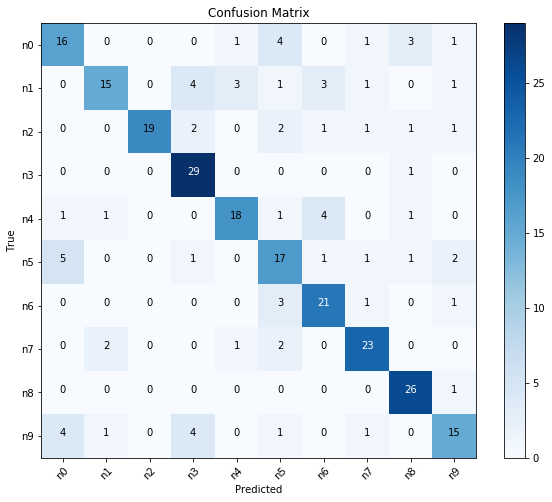

In [6]:
testObj.plot_confusion_matrix(y_true,y_pred)

### Get the True/Prediction classes

In [7]:
xcept_model = testObj.get_xception_model()
y_true,y_pred = testObj.get_true_pred_cls(test,xcept_model)


c:\python36\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


1/1 [==============================] - 0s


1/1 [==============================] - 0s


### Confusion Matrix for Xception Model 

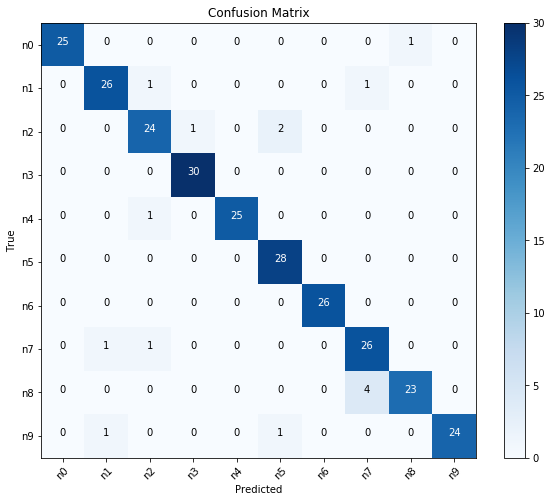

In [8]:
testObj.plot_confusion_matrix(y_true,y_pred)